## FTL EDA:
* All of the useful info is in the section "EDA Visualizations" and after.
* Takeaways and Insights:
    * The orders' avg (lognormalized) rate usd is very, very, very correlated with the distance
        * It's almost so perfectly correlated, that the regression models give very good metrics (see the ridge regression and decision tree metrics at the end)
    * Also, noticeable correlated with the truck's size (palletized linear feet)
    * Some shipping routes are very, very cheap compared to others (which in turn can be helpful determining the avg rate usd of a given order.
        * Specifically, Orders between Seattle, Bay Area, and So-Cal are cheap. Florida to Chicago is cheap.
        * See the plt figure "Origin-to-Dest by Log(rate usd)".
    

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (5,3)
import tqdm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import pylab as pl
from matplotlib import collections  as mc
from sklearn.preprocessing import StandardScaler

import gensim

## Data File Reading

In [2]:
path_folder = os.getcwd()

file_name_oa_offers = "offer_acceptance_offers.csv"
path_file_oa_offers = os.path.join(path_folder, file_name_oa_offers)
oa_offers = pd.read_csv(path_file_oa_offers)
print("Loaded offers df")
print(oa_offers.shape)

file_name_oa_orders = "offer_acceptance_orders.csv"
path_file_oa_orders = os.path.join(path_folder, file_name_oa_orders)
oa_orders = pd.read_csv(path_file_oa_orders)
print("Loaded orders df")
print(oa_orders.shape)

file_name_zipcode_coordinates = "zipcode_coordinates.csv"
path_file_zipcode_coordinates = os.path.join(path_folder, file_name_zipcode_coordinates)
zipcode_coordinates = pd.read_csv(path_file_zipcode_coordinates)
zipcode_coordinates["X_COORD"] /= 1.0e6
zipcode_coordinates["Y_COORD"] /= 1.0e6
print("Loaded zipcodes df")

Loaded offers df
(707418, 14)
Loaded orders df
(280906, 17)
Loaded zipcodes df


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (9,10,11,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#oa_orders = oa_orders[oa_orders["TRANSPORT_MODE"].isin(["PTL"])]
oa_orders = oa_orders[oa_orders["TRANSPORT_MODE"].isin(["FTL"])]

In [4]:
zipcode_coordinates["3DIGIT_ZIP"] = zipcode_coordinates["3DIGIT_ZIP"].astype(int).astype(str).str.zfill(3)

oa_orders = (
    oa_orders
    .merge(zipcode_coordinates, left_on=["DESTINATION_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
    .rename(columns={"X_COORD":"X_COORD_DEST","Y_COORD":"Y_COORD_DEST"})
    .drop(columns=["3DIGIT_ZIP"])
)

oa_orders = (
    oa_orders
    .merge(zipcode_coordinates, left_on=["ORIGIN_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
    .drop(columns=["3DIGIT_ZIP"])
)

## Utility Functions

In [5]:
def dataclean_ftl_duplicate_references(oa_orders):
    '''
    Part of a greater data cleaning on removing incorrect FTL labels,
    Removes FTL rows that have reference numbers that show up more than once, as those rows are incorrectly labeled FTL
    '''
    assert "TRANSPORT_MODE" in oa_orders.columns
    assert "REFERENCE_NUMBER" in oa_orders.columns
    oa_orders_ftl = oa_orders[oa_orders["TRANSPORT_MODE"]=="FTL"]
    oa_orders_ftl_unique = oa_orders_ftl.drop_duplicates(subset=["REFERENCE_NUMBER"],keep=False)
    oa_orders = pd.concat([oa_orders[oa_orders["TRANSPORT_MODE"]!="FTL"], oa_orders_ftl_unique],axis=0)
    oa_orders = oa_orders.reset_index(drop=True)
    assert (oa_orders[oa_orders["TRANSPORT_MODE"]=="FTL"]["REFERENCE_NUMBER"].value_counts()==1).all()
    return oa_orders
def dataclean_ftl_nonquote(oa):
    '''
    Part of a greater data cleaning on removing incorrect FTL labels,
    Removes FTL rows that don't have quote as the transport mode
    '''
    assert "OFFER_TYPE" in oa.columns
    assert "TRANSPORT_MODE" in oa.columns    
    oa = oa[~((oa["TRANSPORT_MODE"]=="FTL") & (oa["OFFER_TYPE"]!="quote"))]
    return oa
def dataclean_pool_reference_numbers_discrepancy(oa_offers):
    '''
    Some oa_offers rows have a mismatch between the length of its reference numbers and its pooled/quote labelling
    These rows are wrong.
    '''
    assert "OFFER_TYPE" in oa_offers.columns
    assert "NUM_REFERENCE_NUMBERS" in oa_offers.columns    
    oa_offers = oa_offers[((oa_offers["OFFER_TYPE"]=="pool") == (oa_offers["NUM_REFERENCE_NUMBERS"]>1))]
    return oa_offers    


def get_log_column(loggable_numerical_column):
    # return column.apply(lambda x: np.log(x+1))
    return loggable_numerical_column.apply(np.log1p)
def add_log_column_to_df(df, column_name):
    '''
    Applies np.log1p (LOG(x+1)) to a numerical column with values >= 0
    And adds it as a column to the df
    '''
    new_column_name = "LOG({0})".format(column_name)
    loggable_numerical_column = df[column_name]
    df[new_column_name] = get_log_column(loggable_numerical_column)
    return df
def get_pd_datetime_column(date_column):
    return pd.to_datetime(date_column)
def convert_pd_datetime_column(df, date_column_name):
    date_column = df[date_column_name] 
    df[date_column_name] = get_pd_datetime_column(date_column)
    return df
def get_boolean_to_num_column(boolean_column):
    return (boolean_column).astype(float)
def convert_boolean_to_num_column(df, boolean_column_name):
    boolean_column = df[boolean_column_name] 
    df[boolean_column_name] = get_boolean_to_num_column(boolean_column)
    return df
def get_list_of_reference_numbers(column):
    '''
    cleans the raw reference column from a string to a list of strings
    '''
    result = (column
    ).str.replace("\n"," "
    ).str.replace(" ",""
    ).str.replace('''"''',''
    ).str.replace("[",""
    ).str.replace("]",""
    ).str.split(",")
    return result

def time_subtraction_weekends_removal(df, time_end_column_name, time_start_column_name):
    start_day_column = pd.to_datetime(df[time_start_column_name]).dt.date
    end_day_column = pd.to_datetime(df[time_end_column_name]).dt.date
    num_business_days_column = np.busday_count( start_day_column , end_day_column)
    num_seconds_in_a_day = 60*60*24
    
    time_between_end_and_start_column = (
        pd.to_datetime(df[time_end_column_name]) - pd.to_datetime(df[time_start_column_name])
    )  
    days_between_end_and_start_column = (
     time_between_end_and_start_column / np.timedelta64(1, 'd')
    )
    weekends_between_end_and_start_column = days_between_end_and_start_column - num_business_days_column
    weekends_between_end_and_start_column_in_seconds = weekends_between_end_and_start_column * num_seconds_in_a_day
    return weekends_between_end_and_start_column_in_seconds
def get_time_subtraction(df, time_end_column_name, time_start_column_name):
    
    time_between_end_and_start_column = (
        pd.to_datetime(df[time_end_column_name]) - pd.to_datetime(df[time_start_column_name])
    )  
    seconds_between_end_and_start_column = (
     time_between_end_and_start_column / np.timedelta64(1, 's')
    )
    weekend_removal = 0
    # TODO: debug time_subtraction_weekends_removal's datetime y/m/d formatting to make this error stop happening
    try:
        weekend_removal = time_subtraction_weekends_removal(df, time_end_column_name, time_start_column_name)
    except:
        print("Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in")
    seconds_between_end_and_start_column -= weekend_removal
    return seconds_between_end_and_start_column    



# oa orders
def add_time_between_order_and_deadline_column(oa_orders, column_name="TIME_BETWEEN_ORDER_AND_DEADLINE"):
    seconds_between_order_and_deadline_column = get_time_subtraction(oa_orders, "PICKUP_DEADLINE_PST","ORDER_DATETIME_PST")
    oa_orders[column_name] = seconds_between_order_and_deadline_column
    return oa_orders
def add_path_column(oa_orders,column_name="PATH"):
    '''
    Adds path (aka shipping route) column to oa orders. path = orig + dest identifier.
    '''
    origin_zipcode_column = oa_orders["ORIGIN_3DIGIT_ZIP"].astype(str)
    destination_zipcode_column = oa_orders["DESTINATION_3DIGIT_ZIP"].astype(str)
    oa_orders[column_name] = origin_zipcode_column + "_TO_" + destination_zipcode_column
    return oa_orders
def add_path_order_amount_column(oa_orders, column_name='PATH_ORDER_AMOUNT'):
    '''
    Adds column denoting number of orders per path to oa orders
    '''
    assert "PATH" in list(oa_orders.columns)
    oa_orders = oa_orders.merge(
        oa_orders.groupby(["PATH"]).size().reset_index(name=column_name), on=["PATH"]
    )
    return oa_orders

# oa offers
def add_cleaned_reference_numbers_column(oa_offers,column_name="REFERENCE_NUMBERS"):
    '''
    Adds column with reference numbers cleaned into a list.
    '''
    oa_offers[column_name] = get_list_of_reference_numbers(oa_offers["REFERENCE_NUMBER"])
    return oa_offers
def add_num_reference_numbers_column(oa_offers,column_name="NUM_REFERENCE_NUMBERS"):
    '''
    Adds number of reference numbers by a carrier (used to find pooled)
    '''
    oa_offers[column_name] = oa_offers["REFERENCE_NUMBERS"].apply(len)
    return oa_offers
def add_offer_type_is_pooled_column(oa_offers,column_name="OFFER_TYPE_IS_POOLED"):
    '''
    Adds if offer type is pooled
    '''
    oa_offers[column_name] = (oa_offers["OFFER_TYPE"]=="pool").astype(float)
    return oa_offers

# oa
def add_offer_order_amount_column(oa,column_name='ORDER_OFFER_AMOUNT'):
    '''
    Adds column denoting number of offers per order ("reference number") to oa_offers
    '''
    reference_numbers_column_name = "REFERENCE_NUMBERS"
    oa = oa.merge(
        oa.groupby([reference_numbers_column_name]).size().reset_index(name=column_name), 
        on=[reference_numbers_column_name])
    #oa = oa.drop(columns=[reference_numbers_column_name,"temp_REFERENCE_NUMBER"])
    return oa
def add_time_between_offer_and_deadline_column(oa, column_name="TIME_BETWEEN_OFFER_AND_DEADLINE"):
    seconds_between_offer_and_deadline_column = get_time_subtraction(oa, "PICKUP_DEADLINE_PST","CREATED_ON_HQ")
    oa[column_name] = seconds_between_offer_and_deadline_column
    return oa
def add_path_offer_amount_column(oa,column_name="PATH_OFFER_AMOUNT"):
    '''
    Adds column denoting number of offers per path
    '''
    assert 'ORDER_OFFER_AMOUNT' in list(oa.columns)
    reference_numbers_column_name = "REFERENCE_NUMBERS"

    temp_groupby = oa.groupby(["PATH",reference_numbers_column_name],as_index=False).agg({"ORDER_OFFER_AMOUNT": np.mean})
    # should be identical to doing oa[["PATH","REFERENCE_NUMBER","ORDER_OFFER_AMOUNT"]].drop_duplicates(subset=["PATH","REFERENCE_NUMBER","ORDER_OFFER_AMOUNT"])
    temp_groupby = temp_groupby.groupby(["PATH"],as_index=False).agg({"ORDER_OFFER_AMOUNT": np.sum})
    temp_groupby = temp_groupby.rename(columns={"ORDER_OFFER_AMOUNT": column_name})
    oa = oa.merge(temp_groupby,on=["PATH"])
    return oa
def add_path_avg_offer_amount_column(oa,column_name="PATH_AVG_OFFER_AMOUNT"):
    '''
    Adds column denoting avg number of offers per path
    '''
    assert 'ORDER_OFFER_AMOUNT' in list(oa.columns)
    reference_numbers_column_name = "REFERENCE_NUMBERS"    
    temp_groupby = oa.groupby(["PATH",reference_numbers_column_name],as_index=False).agg({"ORDER_OFFER_AMOUNT": np.mean})
    # should be identical to doing oa[["PATH","REFERENCE_NUMBER","ORDER_OFFER_AMOUNT"]].drop_duplicates(subset=["PATH","REFERENCE_NUMBER","ORDER_OFFER_AMOUNT"])
    temp_groupby = temp_groupby.groupby(["PATH"],as_index=False).agg({"ORDER_OFFER_AMOUNT": np.mean})
    temp_groupby = temp_groupby.rename(columns={"ORDER_OFFER_AMOUNT": column_name})
    oa = oa.merge(temp_groupby,on=["PATH"])
    return oa

In [6]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib    
from matplotlib import cm

# fig ax bounding points
Y_UPPER_BOUND = 6.5
Y_LOWER_BOUND = 2.5
X_UPPER_BOUND = -7
X_LOWER_BOUND = -15

def bound_ax(ax):
    ax.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
    ax.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
    return ax

def temp_metropolitan_clusters(oa):
    temp = (
        oa
        .groupby(["X_COORD_DEST","Y_COORD_DEST"],as_index=False)
        .agg({"REFERENCE_NUMBERS":"count"})
    )
    #print(len(temp))
    density_dimension_column_name = "REFERENCE_NUMBERS"
    
    do_logging = 1
    div = 10
    eps = 0.15

    if do_logging:
        temp[density_dimension_column_name] = temp[density_dimension_column_name].apply(np.log1p)
    temp[density_dimension_column_name] /= div

    fig0, ax0 = plt.subplots()

    ax0.hist(temp[density_dimension_column_name])

    fig1, ax1 = plt.subplots()
    ax1 = bound_ax(ax1)
    ax1.scatter(
        temp["X_COORD_DEST"],
        temp["Y_COORD_DEST"],
        c=temp[density_dimension_column_name],#temp["PATH_ORDER_AMOUNT"],
        alpha=1,
        s=temp[density_dimension_column_name],
    )

    dbscan = DBSCAN(eps)
    #temp[density_dimension_column_name] /= 100
    np.random.seed(1)
    dbscan.fit(temp[["X_COORD_DEST","Y_COORD_DEST",
                     density_dimension_column_name
                    ]])
    print(pd.Series(dbscan.labels_).value_counts())
    temp["GROUP"] = dbscan.labels_#+1
    temp_ = temp.copy()
    #plt.style.use("ggplot")
    #temp_ = temp_[temp_["GROUP"]==1]
    fig2, ax2 = plt.subplots()
    ax2 = bound_ax(ax2)

    ax2.scatter(
        temp_["X_COORD_DEST"],
        temp_["Y_COORD_DEST"],
        c=temp_["GROUP"],
        cmap="hsv",
        alpha=0.5,
        s=temp_[density_dimension_column_name]*10,
    )
    params = " ".join(["log{0}".format(do_logging),
                        "div{0}".format(div),
                       "dbscan{0}".format(eps),
                      ])
    ax2.set_title(params)
    return temp
    #dbscan = DBSCAN(0.225), np.log1p(PATH_ORDER_AMOUNT)/10



sigmoid = lambda x: x/(1+np.exp(-x))
def visibility_modifier_array(x):
    if agg_column_name not in ["FULL_ZSCORE(LOG(RATE_USD))","GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        return np.log1p(x) 
    else:
        if agg_column_name == "GROUPWISE_ZSCORE(LOG(RATE_USD))":
            return x#**3
        return x
def groupwise_min_max_scale(x):
    numerator = (x - connections["GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))"])
    denominator = (
connections["GROUPWISE_MAX(GROUPWISE_ZSCORE(LOG(RATE_USD)))"] - connections["GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))"]
        )
    rescaled_x = numerator/denominator
    rescaled_x = np.nan_to_num(rescaled_x,0,posinf=0,neginf=0)
    return rescaled_x
def min_max_scale(x):
    numerator = (x - np.min(x))
    denominator = (np.max(x) - np.min(x))
    rescaled_x = numerator/denominator
    rescaled_x = np.nan_to_num(rescaled_x,0,posinf=0,neginf=0)
    return rescaled_x
def visibility_modifier_linewidth(x):
    if agg_column_name not in ["FULL_ZSCORE(LOG(RATE_USD))","GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        return np.log1p(x)  
    else:
        # if x is an array that has numbers below 0 (i.e. a z-scored column), rescale it to be positive
        # since plotted linewidth cannot understand negative width
        # use min-max-scaling to make it positive from 0 to 1
        
        if agg_column_name == "GROUPWISE_ZSCORE(LOG(RATE_USD))":
            rescaled_x = groupwise_min_max_scale(x)
            
            rescaled_x = (1-rescaled_x)**10
        else:
            rescaled_x = min_max_scale(x)
        return rescaled_x**10
def get_values(connections, agg_column_name):
    values = connections[agg_column_name]
    # re-weight the values by usage
    #values /= connections["PATH_ORDER_AMOUNT"]
    return values
def get_linewidths(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    return visibility_modifier_linewidth(values)
def get_array(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    return visibility_modifier_array(values)
def get_rgba(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    #cmap = matplotlib.cm.get_cmap('Spectral')
    cmap = cm.jet
    #cmap = cm.hsv
    norm = matplotlib.colors.Normalize(vmin=np.min(values), vmax=np.max(values))
    rgba_colors = np.array([cmap(norm(x)) for x in values])
    if agg_column_name in ["GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        alphas = (groupwise_min_max_scale(values))#*0.001
    else:
        alphas = (min_max_scale(values))#*0.001
    rgba_colors[:,-1] = (alphas)*0.00001
    return rgba_colors

def path_visualization(oa, agg_column_name):
    path_agg_column_names = ['PATH_OFFER_AMOUNT', 'PATH_AVG_OFFER_AMOUNT','PATH_ORDER_AMOUNT',
           'LOG(PATH_AVG_OFFER_AMOUNT)', 'LOG(PATH_OFFER_AMOUNT)', 'LOG(PATH_ORDER_AMOUNT)', "LOG(RATE_USD)"]
    aggdict = dict()
    for column_name in path_agg_column_names:
        aggdict[column_name] = np.mean
    connections = (oa.groupby(["X_COORD","Y_COORD","X_COORD_DEST","Y_COORD_DEST"],as_index=False).agg(aggdict))
    lines = []
    for i in range(connections.shape[0]):
        row = connections.iloc[i]
        ox = row["X_COORD"]#.values[0]
        oy = row["Y_COORD"]#.values[0]
        dx = row["X_COORD_DEST"]#.values[0]
        dy = row["Y_COORD_DEST"]#.values[0]
        lines.append([(ox, oy), (dx, dy)])

    lc = mc.LineCollection(lines, 
                           array = (get_values(connections, agg_column_name)),
                           cmap="hsv",
                           linewidths = (get_values(connections, agg_column_name))*0.25,
                           alpha=0.05
                          )
    fig2, ax2 = plt.subplots(figsize=(16,8))
    ax2.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
    ax2.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
    ax2.scatter(connections["X_COORD"], connections["Y_COORD"], alpha=0.5, c="yellow", s=2)
    ax2.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
    ax2.add_collection(lc)
    #ax2.autoscale()
    ax2.margins(0.1)
    ax2.set_title("Origin-To-Dest Paths by {0}".format(agg_column_name))
    fig2.colorbar(lc)
    return fig2, ax2

In [7]:
def collapse_oa_into_orders(
    oa,
    oa_orders,
    other_agg_column_names,
    agg_func="mean",
    agg_column_name = "LOG(RATE_USD)",
):
    aggdict = dict()
    aggdict[agg_column_name] = agg_func
    for column_name in other_agg_column_names:
        aggdict[column_name] = "mean"
    order_groupby = oa.groupby(["REFERENCE_NUMBERS"],as_index=False).agg(aggdict)
    result = oa_orders.merge(order_groupby,on=["REFERENCE_NUMBERS"])
    return result

In [8]:
from sklearn.decomposition import PCA
def view_pca(X,y):
    pca = PCA(2)
    Z = pca.fit_transform(X)
    fig, axs = plt.subplots()
    axs.scatter(Z[:,0], Z[:,1], c=y,s=1, alpha=0.1)
    return pca
def temp_regression_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    fig, axs = plt.subplots()
    axs.scatter(prediction, (y_test), alpha=0.1, s=0.1)
    print("Corr between Regression Predicted Y & Actual Y:", np.corrcoef(prediction, (y_test))[0][1])
    return model

## Data Cleaning

In [9]:
oa_offers_boolean_column_names = ['SELF_SERVE', 'IS_OFFER_APPROVED',
           'AUTOMATICALLY_APPROVED', 'MANUALLY_APPROVED', 'WAS_EVER_UNCOVERED',
           'COVERING_OFFER', 'LOAD_DELIVERED_FROM_OFFER', 'RECOMMENDED_LOAD', 'VALID']
oa_offers_date_column_names = ["CREATED_ON_HQ"]
oa_offers_categorical_column_names = ["OFFER_TYPE"]
oa_offers_loggable_numerical_column_names = ["RATE_USD"]

oa_offers = add_cleaned_reference_numbers_column(oa_offers)

oa_offers = add_num_reference_numbers_column(oa_offers)
oa_offers = dataclean_pool_reference_numbers_discrepancy(oa_offers)


oa_offers = add_offer_type_is_pooled_column(oa_offers)
oa_offers_boolean_column_names += ["OFFER_TYPE_IS_POOLED"]

for column_name in oa_offers_date_column_names:
    oa_offers = convert_pd_datetime_column(oa_offers, column_name)
for column_name in oa_offers_boolean_column_names:
    oa_offers = convert_boolean_to_num_column(oa_offers, column_name)
for column_name in oa_offers_loggable_numerical_column_names:
    oa_offers = add_log_column_to_df(oa_offers, column_name)

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [10]:
# Matt said that any duplicate references is likely an error
oa_orders_boolean_column_names = ['FD_ENABLED', 'EXCLUSIVE_USE_REQUESTED','HAZARDOUS', 
                                  'REEFER_ALLOWED', 'STRAIGHT_TRUCK_ALLOWED','LOAD_TO_RIDE_REQUESTED']
oa_orders_loggable_numerical_column_names = ["ESTIMATED_COST_AT_ORDER","APPROXIMATE_DRIVING_ROUTE_MILEAGE",
                                             "PALLETIZED_LINEAR_FEET","LOAD_BAR_COUNT"]
oa_orders_date_column_names = ["ORDER_DATETIME_PST","PICKUP_DEADLINE_PST"]
oa_orders_categorical_column_names = ["DELIVERY_TIME_CONSTRAINT","TRANSPORT_MODE"]

oa_orders = dataclean_ftl_duplicate_references(oa_orders)

oa_orders = add_path_column(oa_orders)
oa_orders = add_path_order_amount_column(oa_orders)
oa_orders = add_time_between_order_and_deadline_column(oa_orders)
oa_orders = add_cleaned_reference_numbers_column(oa_orders)

oa_orders_loggable_numerical_column_names += ["PATH_ORDER_AMOUNT"]

for column_name in oa_orders_date_column_names:
    oa_orders = convert_pd_datetime_column(oa_orders, column_name)
for column_name in oa_orders_boolean_column_names:
    oa_orders = convert_boolean_to_num_column(oa_orders, column_name)
for column_name in oa_orders_loggable_numerical_column_names:
    oa_orders = add_log_column_to_df(oa_orders, column_name)

Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [11]:
oa_offers = oa_offers.explode(["REFERENCE_NUMBERS"])

oa_orders["REFERENCE_NUMBERS"] = oa_orders["REFERENCE_NUMBERS"].apply(lambda x: x[0])
oa_orders = oa_orders.drop(columns=["REFERENCE_NUMBER"])

foreign_key_column_name = "REFERENCE_NUMBERS"
oa = oa_orders.merge(oa_offers, on=[foreign_key_column_name])

In [12]:
oa_boolean_column_names = []

oa = add_time_between_offer_and_deadline_column(oa, column_name="TIME_BETWEEN_OFFER_AND_DEADLINE")
oa = add_offer_order_amount_column(oa, column_name="ORDER_OFFER_AMOUNT")
oa = add_path_offer_amount_column(oa, column_name="PATH_OFFER_AMOUNT")
oa = add_path_avg_offer_amount_column(oa, column_name="PATH_AVG_OFFER_AMOUNT")

oa_numerical_column_names = []
oa_numerical_column_names+=["TIME_BETWEEN_OFFER_AND_DEADLINE"]


oa_loggable_numerical_column_names = []
oa_loggable_numerical_column_names+=["ORDER_OFFER_AMOUNT"]
oa_loggable_numerical_column_names+=["PATH_AVG_OFFER_AMOUNT"]
oa_loggable_numerical_column_names+=["PATH_OFFER_AMOUNT"]

for column_name in oa_loggable_numerical_column_names:
    oa = add_log_column_to_df(oa, column_name)

Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in


In [13]:
other_agg_column_names = []
other_agg_column_names+=oa_offers_boolean_column_names

#other_agg_column_names+=oa_orders_loggable_numerical_column_names
#other_agg_column_names+=oa_orders_boolean_column_names

other_agg_column_names+=oa_numerical_column_names
other_agg_column_names+=oa_loggable_numerical_column_names
other_agg_column_names+=oa_boolean_column_names

target_column_name = "LOG(RATE_USD)"
oa_collapsed_orders = collapse_oa_into_orders(oa,
                                        oa_orders,
                                        other_agg_column_names,
                                        agg_func="mean",
                                        agg_column_name=target_column_name
                                       )

In [14]:
oa_collapsed_orders = oa_collapsed_orders.drop(columns=[
    'ORDER_DATETIME_PST', 
    'PICKUP_DEADLINE_PST',
    'ORIGIN_3DIGIT_ZIP', 
    'DESTINATION_3DIGIT_ZIP',
    'LOG(ESTIMATED_COST_AT_ORDER)',
    'ESTIMATED_COST_AT_ORDER',
    'PATH',
    'REFERENCE_NUMBERS',
])
oa_collapsed_orders = oa_collapsed_orders.drop(columns=[
    'DELIVERY_TIME_CONSTRAINT',
    'TRANSPORT_MODE',
])

oa_collapsed_orders = oa_collapsed_orders.drop(columns=[
    'IS_OFFER_APPROVED', 
    'AUTOMATICALLY_APPROVED',
    'MANUALLY_APPROVED', 
    'COVERING_OFFER',
    'WAS_EVER_UNCOVERED',
    'LOAD_DELIVERED_FROM_OFFER',
])

In [15]:
oa_collapsed_orders = oa_collapsed_orders.fillna(0)
oa_collapsed_orders["APPROXIMATE_DRIVING_ROUTE_MILEAGE"] = (
    (oa_collapsed_orders["X_COORD_DEST"] - oa_collapsed_orders["X_COORD"])**2 + \
    (oa_collapsed_orders["Y_COORD_DEST"] - oa_collapsed_orders["Y_COORD"])**2
)
oa_collapsed_orders["LOG(APPROXIMATE_DRIVING_ROUTE_MILEAGE)"] = (
    oa_collapsed_orders["APPROXIMATE_DRIVING_ROUTE_MILEAGE"].apply(np.log1p)
)

oa_collapsed_orders["DISTANCE_PER_TIME"] = (
    oa_collapsed_orders["APPROXIMATE_DRIVING_ROUTE_MILEAGE"] / oa_collapsed_orders["TIME_BETWEEN_OFFER_AND_DEADLINE"]
)

In [16]:
X = oa_collapsed_orders.drop(columns=[target_column_name])
y = oa_collapsed_orders[target_column_name]

## EDA Visualizations

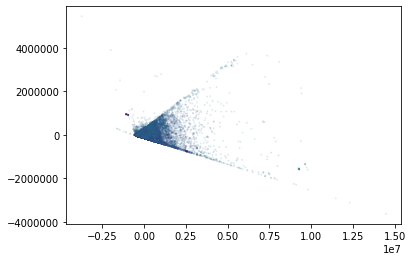

In [17]:
pca = view_pca(X, y)

In [29]:
# correlations with the target column (log rate usd)
oa_collapsed_orders.corr()[target_column_name].abs().sort_values(ascending=False)

LOG(RATE_USD)                             1.000000
LOG(APPROXIMATE_DRIVING_ROUTE_MILEAGE)    0.794636
APPROXIMATE_DRIVING_ROUTE_MILEAGE         0.664985
Y_COORD_DEST                              0.306440
LOG(PALLETIZED_LINEAR_FEET)               0.303331
X_COORD_DEST                              0.255366
PATH_AVG_OFFER_AMOUNT                     0.245236
PALLETIZED_LINEAR_FEET                    0.218946
X_COORD                                   0.162424
ORDER_OFFER_AMOUNT                        0.159068
REEFER_ALLOWED                            0.118441
STRAIGHT_TRUCK_ALLOWED                    0.106904
DISTANCE_PER_TIME                         0.097915
LOAD_TO_RIDE_REQUESTED                    0.069022
LOG(PATH_ORDER_AMOUNT)                    0.060747
SELF_SERVE                                0.038830
VALID                                     0.036355
RECOMMENDED_LOAD                          0.033480
LOAD_BAR_COUNT                            0.029177
LOG(LOAD_BAR_COUNT)            

-1     405
 29    141
 21     28
 12     26
 3      21
 26     15
 23     13
 10     12
 18      9
 15      9
 11      8
 1       8
 14      8
 22      7
 13      7
 6       6
 16      6
 24      6
 4       6
 7       6
 28      5
 2       5
 30      5
 5       5
 20      5
 19      5
 17      5
 0       5
 8       5
 25      4
 27      4
 9       4
dtype: int64


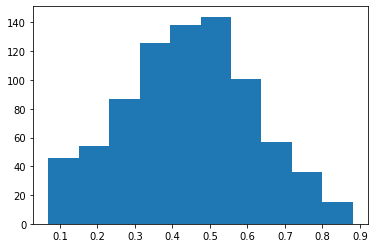

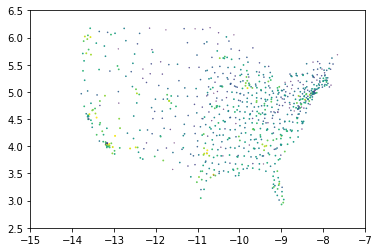

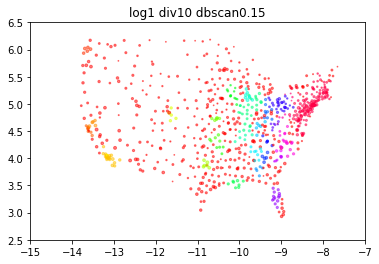

In [18]:
# uncomment this to see the metropolitan zipcodes being clustered into color-coded clumps
color_coded_zipcode_clusters = temp_metropolitan_clusters(oa)

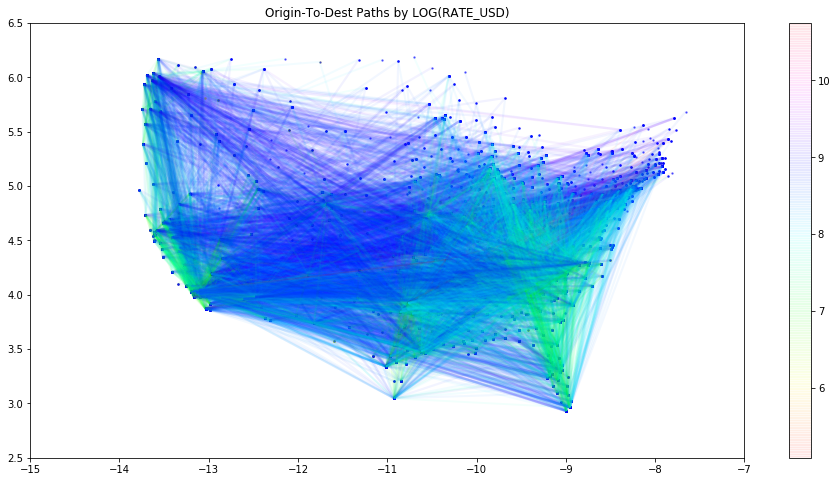

In [19]:
viz_ax = path_visualization(oa,"LOG(RATE_USD)")

#viz_ax = path_visualization(oa,"LOG(PATH_AVG_OFFER_AMOUNT)")

#viz_ax = path_visualization(oa,"LOG(PATH_OFFER_AMOUNT)")

#viz_ax = path_visualization(oa,"LOG(PATH_ORDER_AMOUNT)")

## Model

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.64728e-17): result may not be accurate.
  overwrite_a=True).T


Corr between Regression Predicted Y & Actual Y: 0.8831615700124925


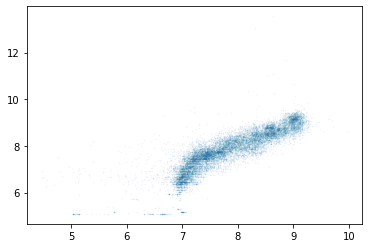

In [24]:
from sklearn.linear_model import Ridge
rr = Ridge()
rr = temp_regression_model(rr, X_train, y_train, X_test, y_test)

Corr between Regression Predicted Y & Actual Y: 0.9545241319381143


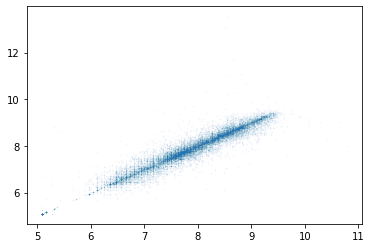

In [25]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr = temp_regression_model(dtr, X_train, y_train, X_test, y_test)

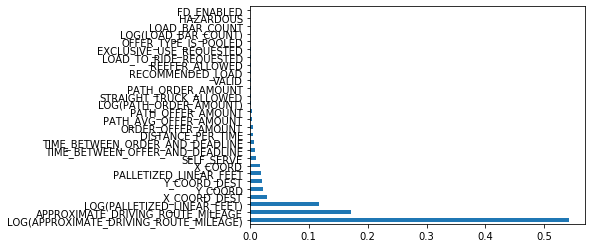

In [26]:
# seeing the most important features of the model
(
    pd.Series(
        index=list(X.columns),
        data=dtr.feature_importances_
    )
    .sort_values(ascending=False)
    .plot(kind="barh")
)